# Exercises

In this section we have two exercises:
1. Implement the polynomial kernel.
2. Implement the multiclass C-SVM.

## Polynomial kernel

You need to extend the ``build_kernel`` function and implement the polynomial kernel if the ``kernel_type`` is set to 'poly'. The equation that needs to be implemented:
\begin{equation}
K=(X^{T}*Y)^{d}.
\end{equation}

In [1]:
# Loading necessary libraries and data (taken from notebook "062_SVM_C")

from sklearn.datasets import load_iris
import numpy as np
from sklearn.model_selection import train_test_split
import cvxopt

iris = load_iris()
data_set = iris.data
labels = iris.target

data_set = data_set[labels!=2]
labels = labels[labels!=2]

train_data_set, test_data_set, train_labels, test_labels = train_test_split(
    data_set, labels, test_size=0.2, random_state=15)

train_labels[train_labels<1] = -1
test_labels[test_labels<1] = -1

objects_count = len(train_labels)

In [2]:
print(np.array(train_data_set).shape[0])
print(np.array(train_data_set).shape[1])

80
4


In [3]:
def build_kernel(data_set, kernel_type='linear', Y = [1, 1], d = 2):
    kernel = np.dot(data_set, data_set.T)
    if kernel_type == 'rbf':
        sigma = 1.0
        objects_count = len(data_set)
        b = np.ones((len(data_set), 1))
        kernel -= 0.5 * (np.dot((np.diag(kernel)*np.ones((1, objects_count))).T, b.T)
                         + np.dot(b, (np.diag(kernel) * np.ones((1, objects_count))).T.T))
        kernel = np.exp(kernel / (2. * sigma ** 2))
    elif kernel_type == 'poly':
        data_set_dim_0 = np.array(data_set).shape[0]
        Y_dim_0 = np.array(Y).shape[0]
        data_set_dim_1 = np.array(data_set).shape[1]
        Y_dim_1 = np.array(Y).shape[1]
        
        if data_set_dim_0 != Y_dim_0:
            return "Error! Wrong Y set length"
            
        if data_set_dim_1 != Y_dim_1:
            return "Error! Wrong Y set width"
            
        kernel = np.power(np.dot(data_set.T, Y), d) 
    return kernel

In [4]:
# Checking with example values

data_set_length = np.array(train_data_set).shape[0]
data_set_width = np.array(train_data_set).shape[1]

Y_example = np.ones(shape = [data_set_length, data_set_width])

# Polynomial kernel
# d = 1
d_example_1 = 1
kernel_1d = build_kernel(train_data_set, kernel_type = 'poly',Y = Y_example,d = d_example_1)
print("Kernel for d = 1:\n",kernel_1d,"\n")

# d = 2
d_example_2 = 2
kernel_2d = build_kernel(train_data_set, kernel_type = 'poly',Y = Y_example,d = d_example_2)
print("Kernel for d = 2:\n",kernel_2d,"\n")

Kernel for d = 1:
 [[439.9 439.9 439.9 439.9]
 [248.9 248.9 248.9 248.9]
 [227.3 227.3 227.3 227.3]
 [ 62.1  62.1  62.1  62.1]] 

Kernel for d = 2:
 [[193512.01 193512.01 193512.01 193512.01]
 [ 61951.21  61951.21  61951.21  61951.21]
 [ 51665.29  51665.29  51665.29  51665.29]
 [  3856.41   3856.41   3856.41   3856.41]] 



## Implement a multiclass C-SVM

Use the classification method that we used in notebook 7.3 and IRIS dataset to build a multiclass C-SVM classifier. Most implementation is about a function that will return the proper data set that need to be used for the prediction. You need to implement:
- ``choose_set_for_label``
- ``get_labels_count``

In [5]:
import numpy as np
import cvxopt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
%matplotlib inline

In [6]:
#def choose_set_for_label(data_set, label):
    # your code here
#    return train_data_set, test_data_set, train_labels, test_labels

In [7]:
def choose_set_for_label(train_labels, test_labels, treshold):
    
    train_labels[train_labels < treshold] = -1
    test_labels[test_labels < treshold] = -1

    train_labels[train_labels >= treshold] = 1
    test_labels[test_labels >= treshold] = 1
    
    return train_labels, test_labels 

In [8]:
#def get_labels_count(data_set):
#    return labels_count

In [9]:
# Use the code that we have implemented earlier:

In [10]:
def train(train_data_set, train_labels, kernel_type='linear', C=10, threshold=1e-5):
    kernel = build_kernel(train_data_set, kernel_type=kernel_type)

    P = train_labels * train_labels.transpose() * kernel
    q = -np.ones((objects_count, 1))
    G = np.concatenate((np.eye(objects_count), -np.eye(objects_count)))
    h = np.concatenate((C * np.ones((objects_count, 1)), np.zeros((objects_count, 1))))

    A = train_labels.reshape(1, objects_count)
    A = A.astype(float)
    b = 0.0

    sol = cvxopt.solvers.qp(cvxopt.matrix(P), cvxopt.matrix(q), cvxopt.matrix(G), cvxopt.matrix(h), cvxopt.matrix(A), cvxopt.matrix(b))

    lambdas = np.array(sol['x'])

    support_vectors_id = np.where(lambdas > threshold)[0]
    vector_number = len(support_vectors_id)
    support_vectors = train_data_set[support_vectors_id, :]

    lambdas = lambdas[support_vectors_id]
    targets = train_labels[support_vectors_id]

    b = np.sum(targets)
    for n in range(vector_number):
        b -= np.sum(lambdas * targets * np.reshape(kernel[support_vectors_id[n], support_vectors_id], (vector_number, 1)))
    b /= len(lambdas)

    return lambdas, support_vectors, support_vectors_id, b, targets, vector_number

In [11]:
def build_kernel(data_set, kernel_type='linear'):
    kernel = np.dot(data_set, data_set.T)
    if kernel_type == 'rbf':
        sigma = 1.0
        objects_count = len(data_set)
        b = np.ones((len(data_set), 1))
        kernel -= 0.5 * (np.dot((np.diag(kernel)*np.ones((1, objects_count))).T, b.T)
                         + np.dot(b, (np.diag(kernel) * np.ones((1, objects_count))).T.T))
        kernel = np.exp(kernel / (2. * sigma ** 2))
    return kernel

In [12]:
def classify_rbf(test_data_set, train_data_set, lambdas, targets, b, vector_number, support_vectors, support_vectors_id):
    kernel = np.dot(test_data_set, support_vectors.T)
    sigma = 1.0
    #K = np.dot(test_data_set, support_vectors.T)
    #kernel = build_kernel(train_data_set, kernel_type='rbf')
    c = (1. / sigma * np.sum(test_data_set ** 2, axis=1) * np.ones((1, np.shape(test_data_set)[0]))).T
    c = np.dot(c, np.ones((1, np.shape(kernel)[1])))
    #aa = np.dot((np.diag(K)*np.ones((1,len(test_data_set)))).T[support_vectors_id], np.ones((1, np.shape(K)[0]))).T
    sv = (np.diag(np.dot(train_data_set, train_data_set.T))*np.ones((1,len(train_data_set)))).T[support_vectors_id]
    aa = np.dot(sv,np.ones((1,np.shape(kernel)[0]))).T
    kernel = kernel - 0.5 * c - 0.5 * aa
    kernel = np.exp(kernel / (2. * sigma ** 2))

    y = np.zeros((np.shape(test_data_set)[0], 1))
    for j in range(np.shape(test_data_set)[0]):
        for i in range(vector_number):
            y[j] += lambdas[i] * targets[i] * kernel[j, i]
        y[j] += b
    return np.sign(y)

In [13]:
# modify this part 
# lambdas, support_vectors, support_vectors_id, b, targets, vector_number = train(train_data_set, train_labels, kernel_type='rbf')
# predicted = classify_rbf(test_data_set, train_data_set, lambdas, targets, b, vector_number, support_vectors, support_vectors_id)
# predicted = list(predicted.astype(int))

# from sklearn.metrics import accuracy_score

# print(accuracy_score(predicted, test_labels))

In [14]:
# Load data

iris = load_iris()
data_set = iris.data
labels = iris.target

# Divide into training and testing sets
train_data_set, test_data_set, train_labels, test_labels = train_test_split(data_set, labels, test_size=0.2, random_state=15)

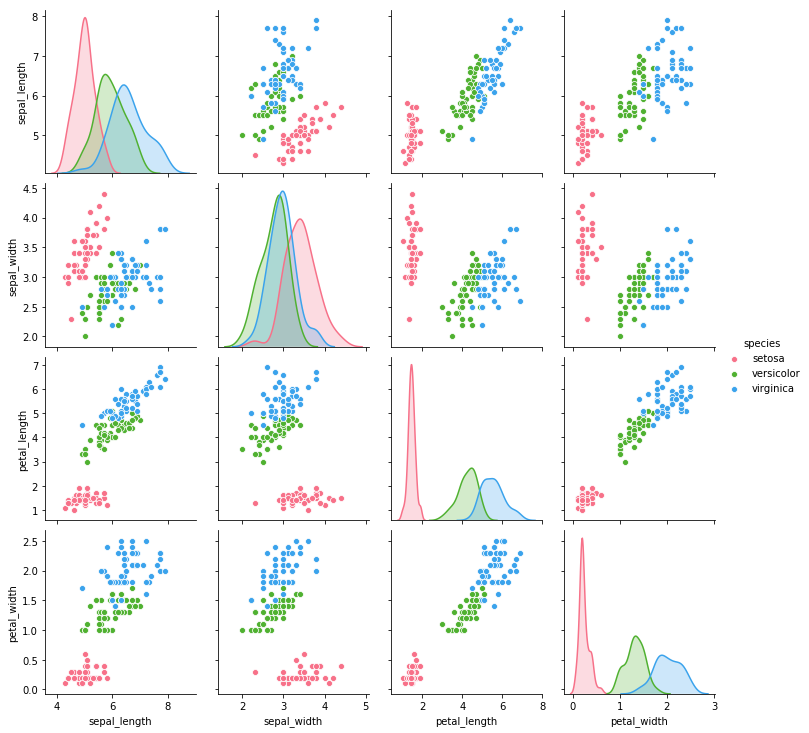

In [15]:
iris = sns.load_dataset("iris")
sns.pairplot(iris, hue="species", palette = 'husl');

In [16]:
print("In general one way to implement classification for three classes would be to use 1vsALL method three times for each class vs the rest. However, judging by the variable distribution histograms, it would be difficult to make a 1vsALL classiffication with a flat hyperplane between versicolor vs setosa+virginica. Moreover the sets can be classified in just two steps. First using 1vsALL method to distinguish between setosa VS (versicolor+virginica) and in next step 1vs1 distinguishing versicolor vs virginica.")

In general one way to implement classification for three classes would be to use 1vsALL method three times for each class vs the rest. However, judging by the variable distribution histograms, it would be difficult to make a 1vsALL classiffication with a flat hyperplane between versicolor vs setosa+virginica. Moreover the sets can be classified in just two steps. First using 1vsALL method to distinguish between setosa VS (versicolor+virginica) and in next step 1vs1 distinguishing versicolor vs virginica.


In [17]:
# 1 vs ALL method - starting with setosa VS (versicolor+virginica)

# Copy of dataset (to avoid altering original data)
train_data_set_1 = np.copy(train_data_set)
test_data_set_1 = np.copy(test_data_set)

train_labels_1 = np.copy(train_labels)
test_labels_1 = np.copy(test_labels)

# Change labeling for setosa VS (versicolor+virginica) classification
train_labels_1, test_labels_1 = choose_set_for_label(train_labels_1, test_labels_1, treshold = 1)

In [18]:
objects_count = len(train_data_set)

# Training
lambdas, support_vectors, support_vectors_id, b, targets, vector_number = train(train_data_set_1, train_labels_1, kernel_type='rbf')

# Predicting
predicted = classify_rbf(test_data_set, train_data_set, lambdas, targets, b, vector_number, support_vectors, support_vectors_id)
predicted = list(predicted.astype(int))

     pcost       dcost       gap    pres   dres
 0:  1.1726e+02 -1.7992e+03  4e+03  2e-01  2e-15
 1:  7.7967e+01 -1.6973e+02  3e+02  5e-03  2e-15
 2:  1.0169e+01 -2.2323e+01  3e+01  6e-16  3e-15
 3: -4.9607e-01 -4.9938e+00  4e+00  2e-16  1e-15
 4: -1.4344e+00 -2.5218e+00  1e+00  2e-16  4e-16
 5: -1.6897e+00 -2.1674e+00  5e-01  2e-16  2e-16
 6: -1.8078e+00 -2.0073e+00  2e-01  1e-16  2e-16
 7: -1.8464e+00 -1.9763e+00  1e-01  2e-16  2e-16
 8: -1.8825e+00 -1.9020e+00  2e-02  2e-16  2e-16
 9: -1.8902e+00 -1.8906e+00  4e-04  2e-16  2e-16
10: -1.8904e+00 -1.8904e+00  5e-06  2e-16  2e-16
11: -1.8904e+00 -1.8904e+00  5e-08  2e-16  2e-16
Optimal solution found.


In [19]:
print("Accuracy =", accuracy_score(predicted, test_labels_1))

Accuracy = 0.26666666666666666


In [20]:
# Step 2 - distinguish versicolor from virginica

# Change labeling
train_labels[train_labels_1 == -1] = 0
test_labels[test_labels_1 == -1] = 0

# Remove already identified setosa from dataset
train_data_set_2 = np.copy(train_data_set[train_labels_1 != -1 ] )
test_data_set_2 = np.copy(test_data_set[test_labels_1 != -1])

train_labels_2 = np.copy(train_labels[train_labels_1 != -1])
test_labels_2 = np.copy(test_labels[test_labels_1 != -1])

# Set new labels for versicolor vs virginica classification
train_labels_2, test_labels_2 = choose_set_for_label(train_labels_2, test_labels_2, treshold = 2)

objects_count = len(train_data_set_2)

# Training
lambdas, support_vectors, support_vectors_id, b, targets, vector_number = train(train_data_set_2, train_labels_2, kernel_type='rbf')

# Predicting
predicted = classify_rbf(test_data_set_2, train_data_set_2, lambdas, targets, b, vector_number, support_vectors, support_vectors_id)
predicted = list(predicted.astype(int))

     pcost       dcost       gap    pres   dres
 0:  8.1368e+01 -1.3274e+03  3e+03  2e-01  2e-15
 1:  5.6550e+01 -1.2265e+02  2e+02  6e-03  2e-15
 2:  7.3591e+00 -1.6069e+01  2e+01  1e-15  3e-15
 3: -3.6328e-01 -3.5955e+00  3e+00  2e-16  1e-15
 4: -1.0880e+00 -1.7230e+00  6e-01  2e-16  4e-16
 5: -1.2291e+00 -1.4226e+00  2e-01  2e-16  2e-16
 6: -1.2892e+00 -1.4054e+00  1e-01  3e-16  2e-16
 7: -1.3235e+00 -1.3522e+00  3e-02  2e-16  2e-16
 8: -1.3334e+00 -1.3351e+00  2e-03  2e-16  2e-16
 9: -1.3342e+00 -1.3342e+00  3e-05  2e-16  2e-16
10: -1.3342e+00 -1.3342e+00  3e-07  2e-16  2e-16
Optimal solution found.


In [21]:
test_labels_2[test_labels_2 == 1] = -1
test_labels_2[test_labels_2 == 2] = 1

In [22]:
print("Accuracy =", accuracy_score(predicted, test_labels_2))

Accuracy = 1.0
